In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [5]:
# Define paths to your data directories
train_data_dir = '/content/drive/MyDrive/ml2025/train-images'
test_data_dir = '/content/drive/MyDrive/ml2025/TEST_images/TEST_images'

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest',
                                   validation_split=0.2
                                  )

test_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Create training, validation, and test datasets using image_dataset_from_directory
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ml2025/train-images',
    subset="training",
    seed=123,
    class_mode='binary',
    classes=['unpleasant','pleasant'],
    target_size=(224, 224),
    shuffle=True,
    batch_size=128
)

Found 5102 images belonging to 2 classes.


In [8]:
val_ds = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/ml2025/train-images',
    subset="validation",
    seed=123,
    target_size=(224, 224),
    class_mode='binary',
    classes=['unpleasant','pleasant'],
    batch_size=128,
    shuffle=False
)

Found 1274 images belonging to 2 classes.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, Xception, ResNet50

# Load the pre-trained model without the classification layer

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
def extract_features(generator):
    features = base_model.predict(generator, verbose=1)
    features = features.reshape(features.shape[0], -1)
    labels = generator.classes
    return features, labels


In [ ]:
import numpy as np
import pandas as pd
import os

csv_data = pd.read_csv('/content/drive/MyDrive/ml2025/Test-IDs.csv')

target_height, target_width = 224, 224
batch_size = 128

# 2. Create a list of full paths in the correct order
test_filepaths = [os.path.join(test_data_dir, filename) for filename in csv_data['Filename']]

# 3. Create a TensorFlow Dataset manually
def load_and_preprocess_image(path):
    # Load and preprocess each image
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [target_height, target_width])
    image = image / 255.0  # Normalize
    return image


test_dataset = tf.data.Dataset.from_tensor_slices(test_filepaths)
test_dataset = test_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

def extract_features_from_test(dataset):
    features = []
    for batch_x in dataset:  # No labels for test set
        # Extract features using the pre-trained model
        batch_features = base_model.predict(batch_x)
        # Flatten the features
        batch_features = batch_features.reshape(batch_features.shape[0], -1)
        features.extend(batch_features)
    return np.array(features)



In [ ]:
X_train, y_train = extract_features(train_generator)

40/40 ━━━━━━━━━━━━━━━━━━━━ 2061s 53s/step


In [ ]:
X_val, y_val = extract_features(val_ds)

10/10 ━━━━━━━━━━━━━━━━━━━━ 317s 35s/step


In [ ]:
X_test = extract_features_from_test(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


In [ ]:
# Save the sets in order to compute them only one time


np.save('/content/drive/MyDrive/ml2025/X_train.npy', X_train)
np.save('/content/drive/MyDrive/ml2025/y_train.npy', y_train)
np.save('/content/drive/MyDrive/ml2025/X_val.npy', X_val)
np.save('/content/drive/MyDrive/ml2025/y_val.npy', y_val)
np.save('/content/drive/MyDrive/ml2025/X_test.npy', X_test)


**Load The Precomputed Data**

In [9]:
X_train = np.load('/content/drive/MyDrive/ml2025/X_train.npy')
y_train = np.load('/content/drive/MyDrive/ml2025/y_train.npy')
X_val = np.load('/content/drive/MyDrive/ml2025/X_val.npy')
y_val = np.load('/content/drive/MyDrive/ml2025/y_val.npy')
X_test = np.load('/content/drive/MyDrive/ml2025/X_test.npy')

**Scale Features**

In [10]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScaler object
scaler = StandardScaler()

In [11]:
# Transform the training and validation features
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [12]:
print(X_train_scaled.shape)
print(X_val_scaled.shape)
print(X_test_scaled.shape)

(5102, 100352)
(1274, 100352)
(500, 100352)


**PCA Components**

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce to M components

for i in [2, 3, 5, 10, 20]:
  pca = PCA(n_components=i)
  X_train_pca = pca.fit_transform(X_train_scaled)
  X_val_pca = pca.transform(X_val_scaled)
  X_test_pca = pca.transform(X_test_scaled)

  np.save(f'/content/drive/MyDrive/ml2025/X_train_pca{i}.npy', X_train_pca)

  np.save(f'/content/drive/MyDrive/ml2025/X_val_pca{i}.npy', X_val_pca)

  np.save(f'/content/drive/MyDrive/ml2025/X_test_pca{i}.npy', X_test_pca)


**Plot the PCA Data**

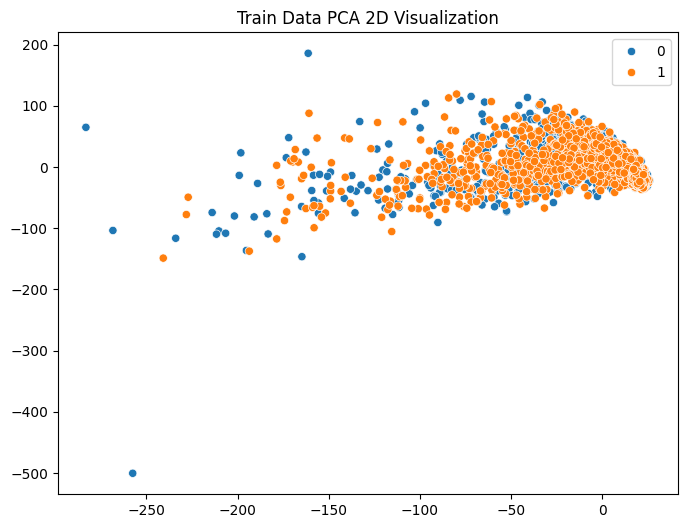

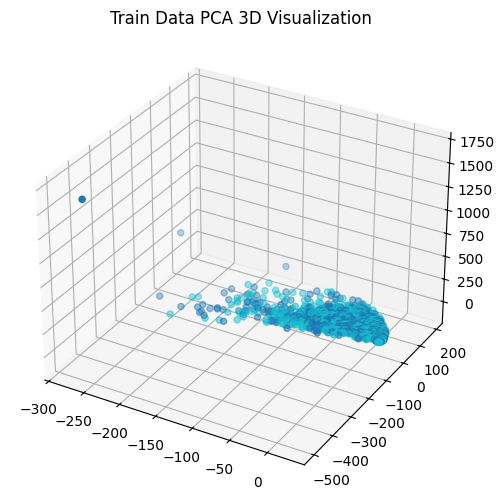

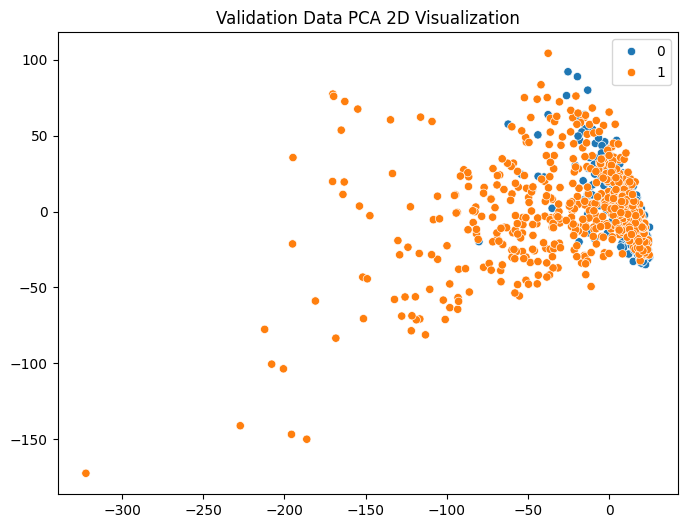

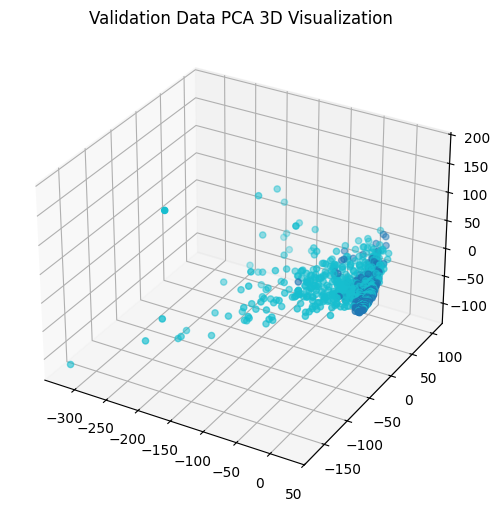

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

X_train_pca3 = np.load('/content/drive/MyDrive/ml2025/X_train_pca3.npy')
X_val_pca3 = np.load('/content/drive/MyDrive/ml2025/X_val_pca3.npy')


data_to_plot = [
    (X_train_pca3, y_train, "Train Data PCA 3D Visualization"),
    (X_val_pca3, y_val, "Validation Data PCA 3D Visualization"),
]


for pca_set, labels, title in data_to_plot:

    # 2D plot - Use the corresponding labels for hue
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=pca_set[:, 0], y=pca_set[:, 1], hue=labels, palette='tab10')
    plt.title(title.replace("3D", "2D")) # Adjust title for 2D plot
    plt.show()

    # 3D plot - Use the corresponding labels for color
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pca_set[:, 0], pca_set[:, 1], pca_set[:, 2], c=labels, cmap='tab10')
    plt.title(title)
    plt.show()


**Locally Linear Embedding (LLE)**

In [ ]:
import numpy as np
from sklearn.manifold import LocallyLinearEmbedding

for i in [2, 3, 5, 10, 20]:

  # 1. Create an LLE object
  embedding = LocallyLinearEmbedding(n_components=i, n_neighbors=10)

  # 2. Fit LLE on the training data and transform
  X_train_lle = embedding.fit_transform(X_train_scaled)

  # 3. Transform the validation and test data using the fitted LLE model
  X_val_lle = embedding.transform(X_val_scaled)
  X_test_lle = embedding.transform(X_test_scaled)


  np.save(f'/content/drive/MyDrive/ml2025/X_train_lle{i}.npy', X_train_lle)

  np.save(f'/content/drive/MyDrive/ml2025/X_val_lle{i}.npy', X_val_lle)

  np.save(f'/content/drive/MyDrive/ml2025/X_test_lle{i}.npy', X_test_lle)



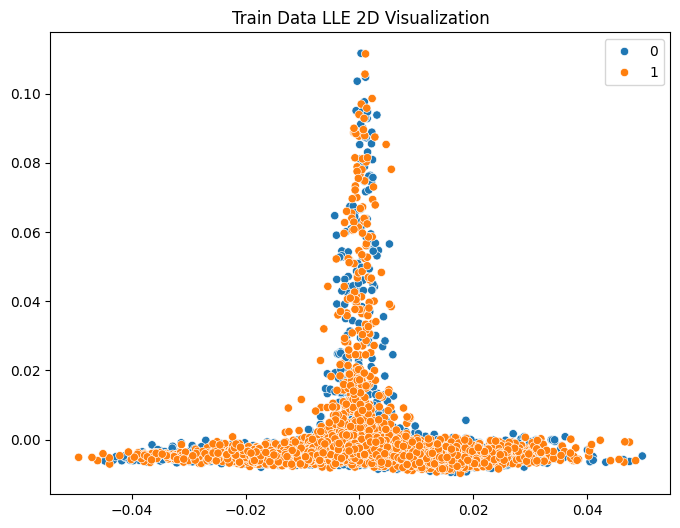

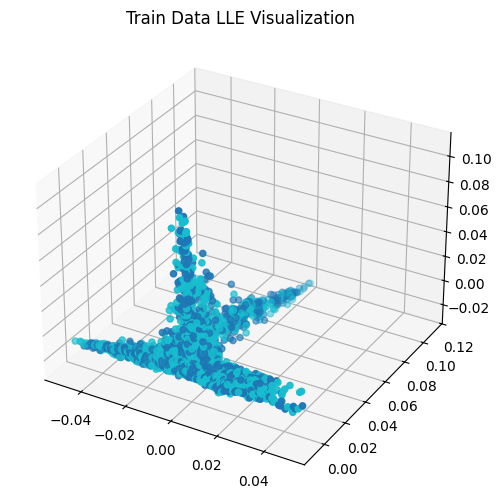

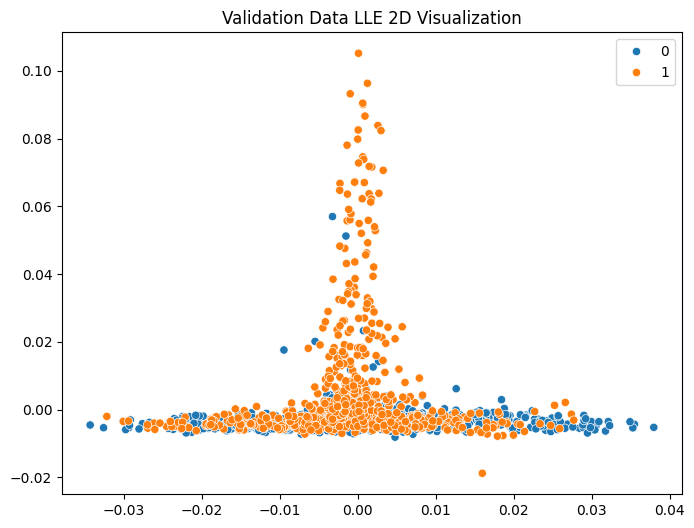

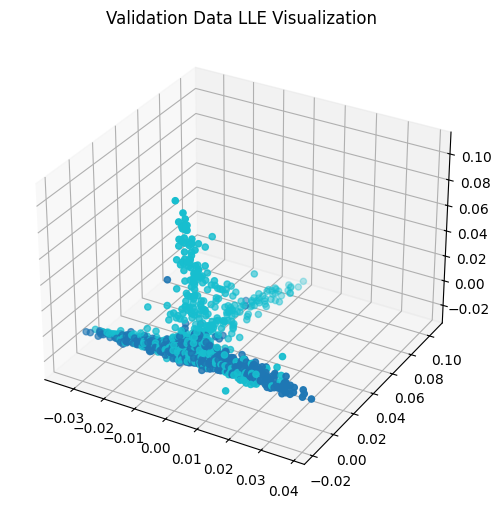

In [ ]:
X_train_lle3 = np.load(f'/content/drive/MyDrive/ml2025/X_train_lle3.npy')
X_val_lle3 = np.load(f'/content/drive/MyDrive/ml2025/X_val_lle3.npy')


data_to_plot_lle = [
    (X_train_lle3, y_train, f"Train Data LLE Visualization"),
    (X_val_lle3, y_val, f"Validation Data LLE Visualization"),
]

for lle_set, labels, title in data_to_plot_lle:

    # 2D plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=lle_set[:, 0], y=lle_set[:, 1], hue=labels, palette='tab10')
    plt.title(title.replace("Visualization", "2D Visualization")) # Adjust title
    plt.show()

    # 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(lle_set[:, 0], lle_set[:, 1], lle_set[:, 2], c=labels, cmap='tab10')
    plt.title(title)
    plt.show()

**Autoencoder With Two Hidden Layers**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense

def build_autoencoder(input_dim, latent_dim):
    # Encoder
    encoder_input = Input(shape=(input_dim,))
    x = Dense(256, activation='relu')(encoder_input)
    x = Dense(128, activation='relu')(x)
    encoded = Dense(latent_dim, activation='relu')(x)

    # Decoder
    x = Dense(128, activation='relu')(encoded)
    x = Dense(256, activation='relu')(x)
    decoded = Dense(input_dim, activation='sigmoid')(x)

    # Full autoencoder
    autoencoder = keras.Model(encoder_input, decoded)
    encoder = keras.Model(encoder_input, encoded)

    return autoencoder, encoder


In [ ]:
for M in [2, 3, 5, 10, 20]:
    print(f"\nTraining Autoencoder with latent dimension M={M}")

    autoencoder, encoder = build_autoencoder(input_dim=X_train_scaled.shape[1], latent_dim=M)
    autoencoder.compile(optimizer='adam', loss='mse')

    autoencoder.fit(X_train_scaled, X_train_scaled,
                    epochs=50,
                    batch_size=32,
                    validation_data=(X_val_scaled, X_val_scaled),
                    verbose=0)

    # Get encoded features
    X_train_encoded = encoder.predict(X_train_scaled)
    X_val_encoded = encoder.predict(X_val_scaled)
    X_test_encoded = encoder.predict(X_test_scaled)

    np.save(f'/content/drive/MyDrive/ml2025/X_train_encoded{M}.npy', X_train_encoded)

    np.save(f'/content/drive/MyDrive/ml2025/X_val_encoded{M}.npy', X_val_encoded)

    np.save(f'/content/drive/MyDrive/ml2025/X_test_encoded{M}.npy', X_test_encoded)





Training Autoencoder with latent dimension M=2
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step

Training Autoencoder with latent dimension M=3
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Training Autoencoder with latent dimension M=5
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Training Autoencoder with latent dimension M=10
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step

Training Autoencoder with latent dimension M=20
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


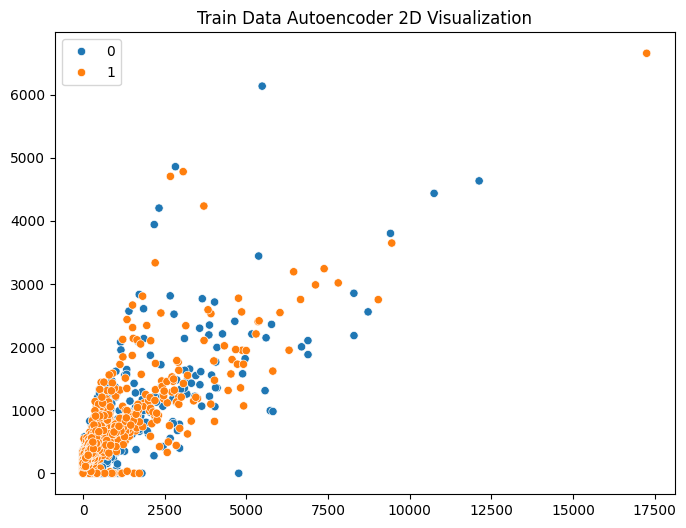

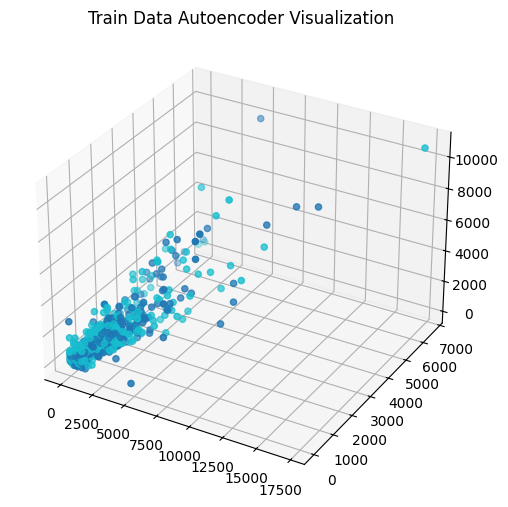

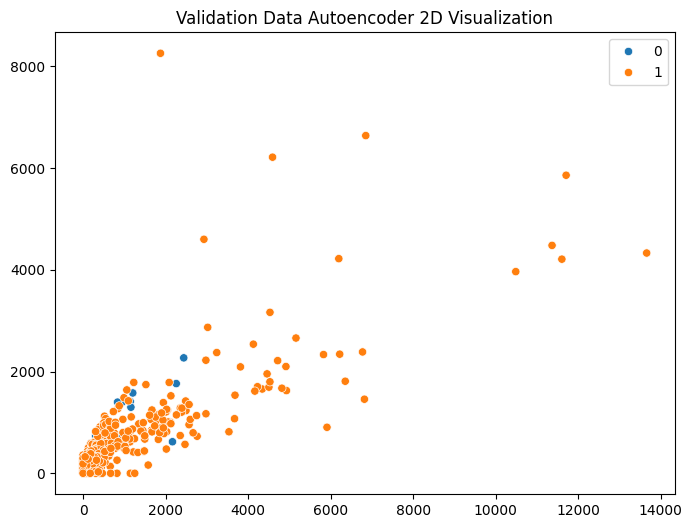

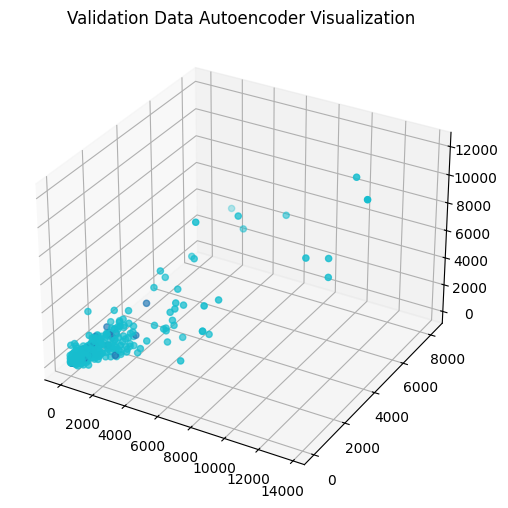

In [ ]:
X_train_encoded3 = np.load(f'/content/drive/MyDrive/ml2025/X_train_encoded3.npy')
X_val_encoded3 = np.load(f'/content/drive/MyDrive/ml2025/X_val_encoded3.npy')


data_to_plot_encoded = [
    (X_train_encoded3, y_train, f"Train Data Autoencoder Visualization"),
    (X_val_encoded3, y_val, f"Validation Data Autoencoder Visualization"),
]

for encoded_set, labels, title in data_to_plot_encoded:

    # 2D plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=encoded_set[:, 0], y=encoded_set[:, 1], hue=labels, palette='tab10')
    plt.title(title.replace("Visualization", "2D Visualization")) # Adjust title
    plt.show()

    # 3D plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(encoded_set[:, 0], encoded_set[:, 1], encoded_set[:, 2], c=labels, cmap='tab10')
    plt.title(title)
    plt.show()

**K-Means**

In [ ]:
pip install permetrics==2.0.0


Evaluating PCA with M=2


pca-2:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating PCA with M=3


pca-3:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating PCA with M=5


pca-5:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating PCA with M=10


pca-10:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating PCA with M=20


pca-20:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating LLE with M=2


lle-2:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating LLE with M=3


lle-3:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating LLE with M=5


lle-5:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating LLE with M=10


lle-10:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating LLE with M=20


lle-20:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating ENCODED with M=2


encoded-2:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating ENCODED with M=3


encoded-3:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating ENCODED with M=5


encoded-5:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating ENCODED with M=10


encoded-10:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating ENCODED with M=20


encoded-20:   0%|          | 0/9 [00:00<?, ?it/s]


Completed all evaluations!

Top 10 configurations by F1 Score:
      Method  Dimensions   K   Distance  F1_Score    Purity  Silhouette
182  encoded           2   3  euclidean  0.537194  0.545526   -0.003862
114      lle           3   5  euclidean  0.534513  0.534537    0.005440
215  encoded           3  10     cosine  0.531508  0.531397   -0.001770
213  encoded           3   9     cosine  0.530041  0.574568    0.016643
146      lle          10   3  euclidean  0.527145  0.558085    0.003632
222  encoded           5   5  euclidean  0.526657  0.577708   -0.008307
116      lle           3   6  euclidean  0.526027  0.611460   -0.008074
265  encoded          20   8     cosine  0.524750  0.558870   -0.008601
224  encoded           5   6  euclidean  0.522915  0.585557   -0.014703
118      lle           3   7  euclidean  0.522757  0.551805    0.006154

Top 10 configurations by Silhouette Score:
      Method  Dimensions  K   Distance  Silhouette  F1_Score    Purity
220  encoded           5  4  

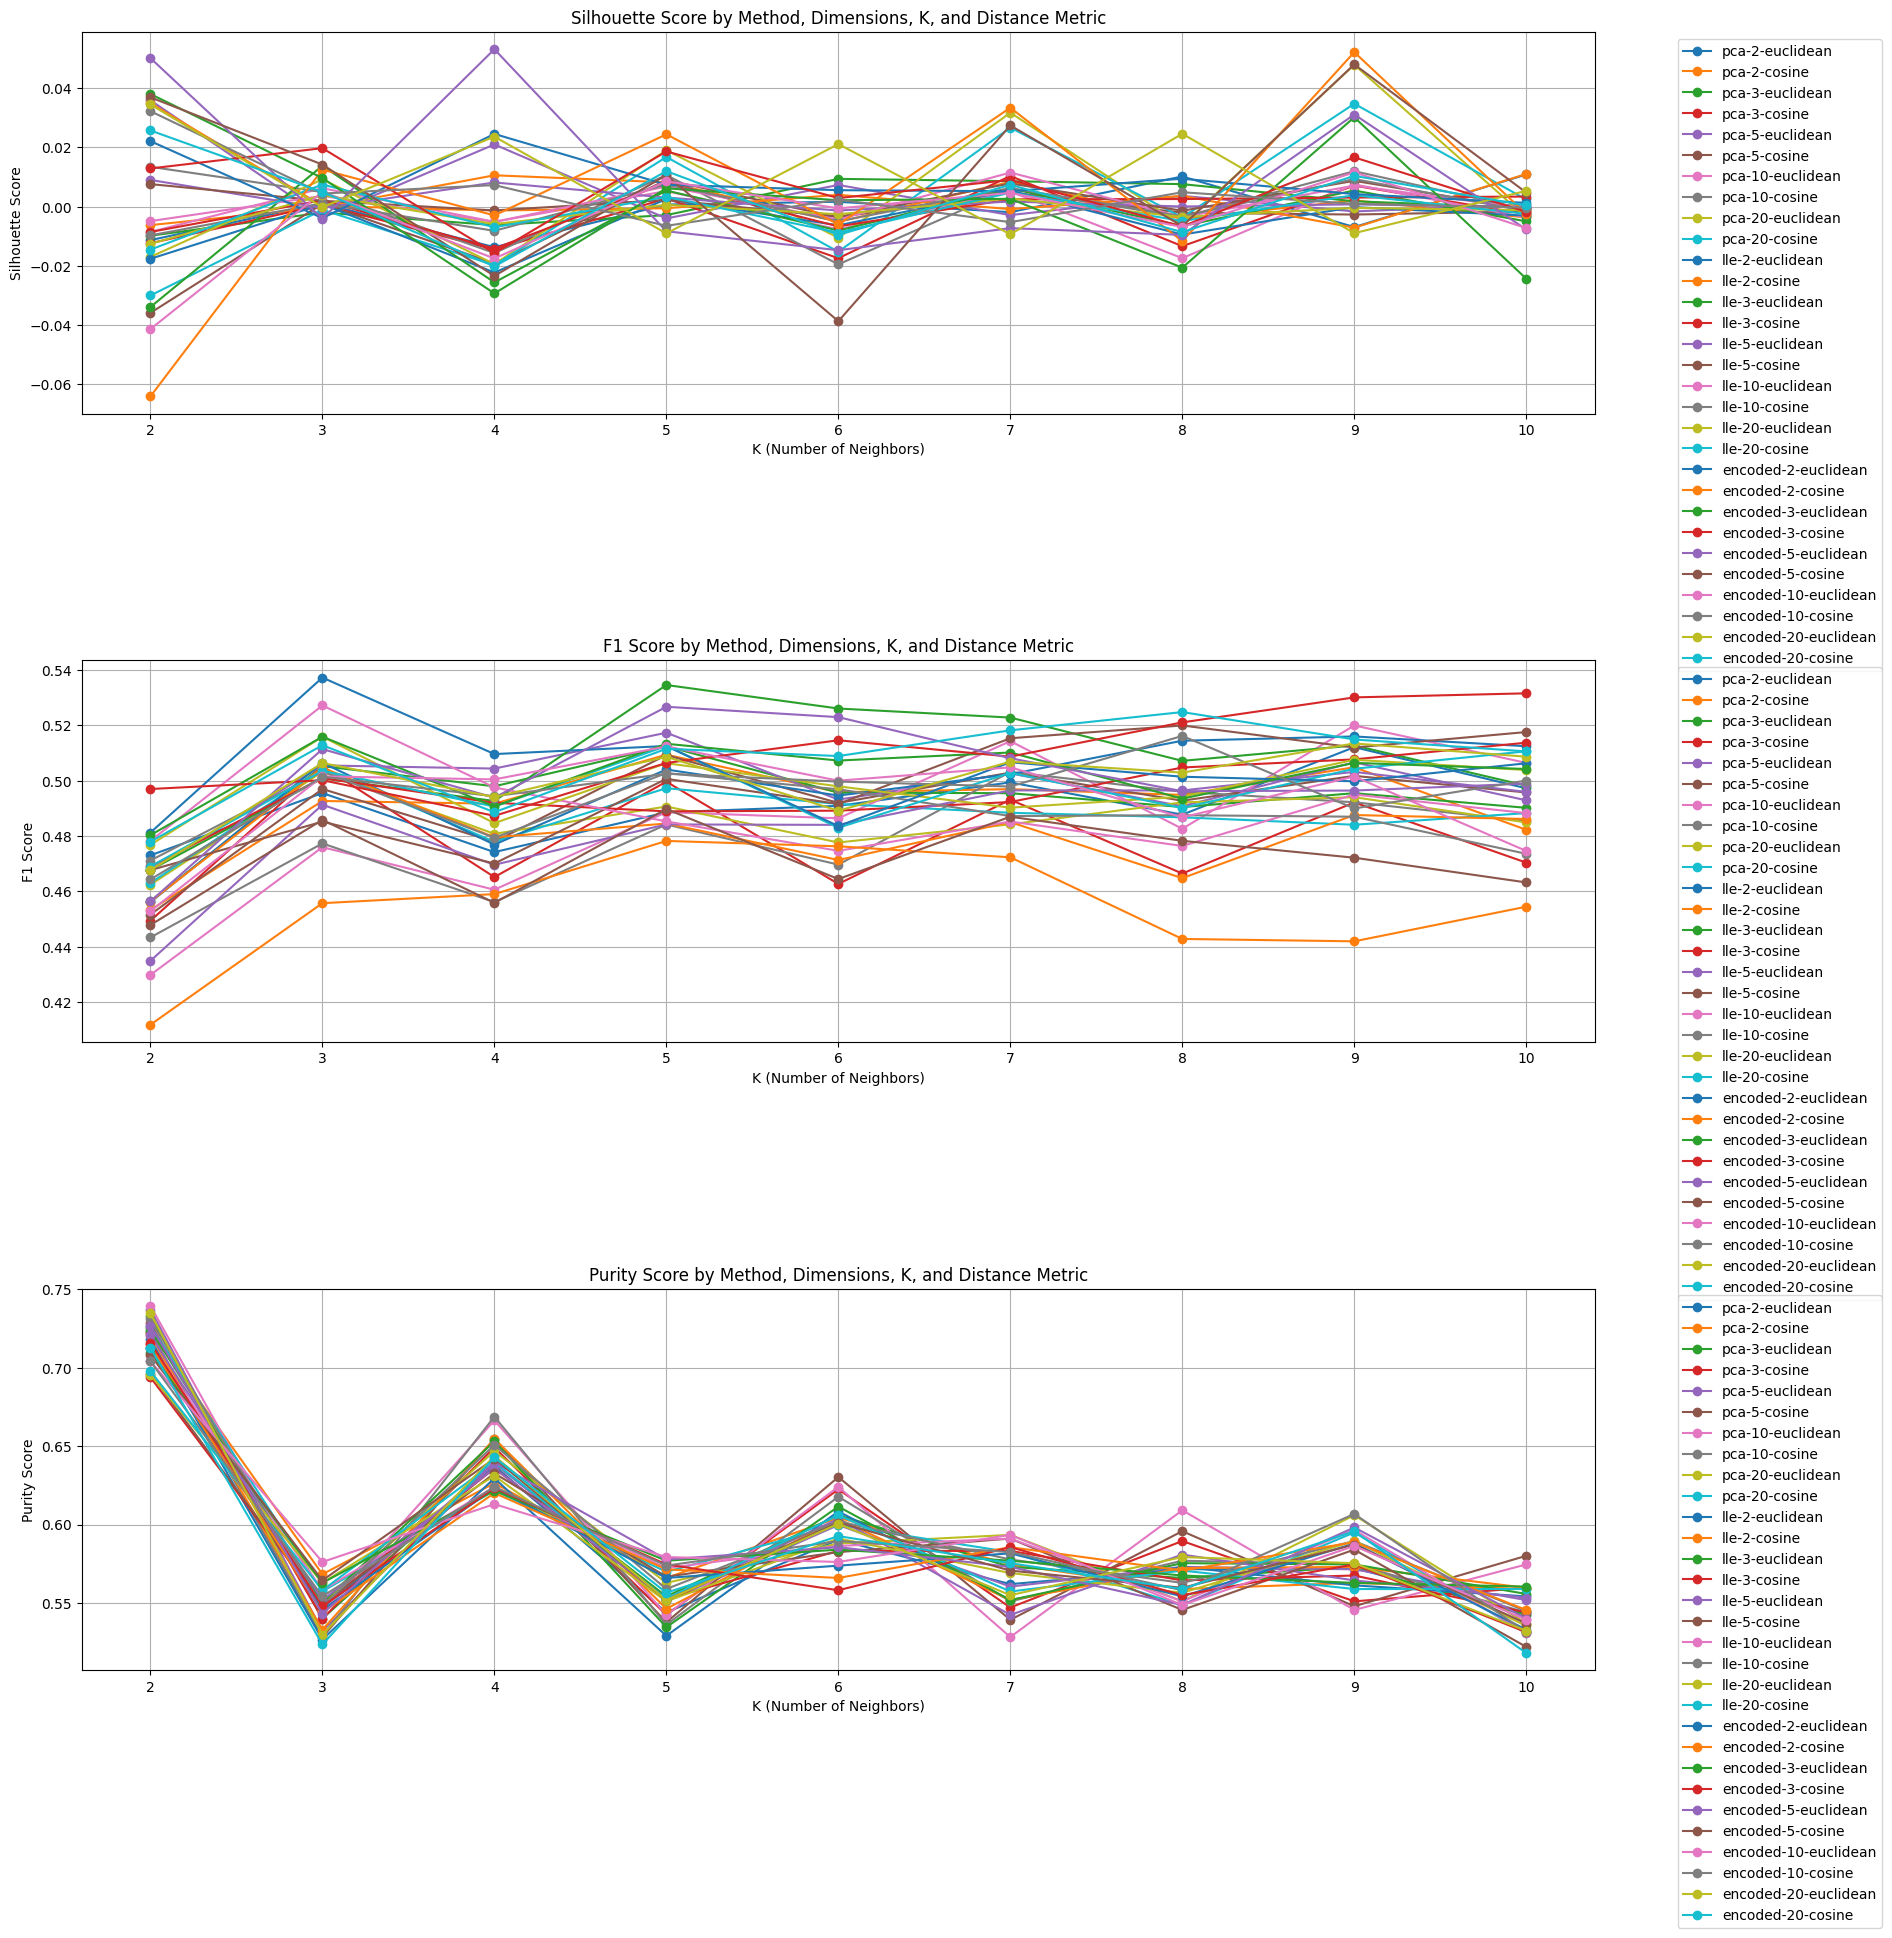

In [51]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, silhouette_score
from permetrics import ClusteringMetric
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

# Define parameters to test
methods = ['pca', 'lle', 'encoded']
dimensions = [2, 3, 5, 10, 20]
k_values = range(2, 11)
metrics = ['euclidean', 'cosine']

# Initialize a dataframe to store results
results = []

# Main evaluation loop
for method in methods:
    for M in dimensions:
        try:
            # Load data based on dimensionality reduction method
            if method == 'encoded':
                # Assuming autoencoder embeddings are saved with different naming convention
                X_train = np.load(f'/content/drive/MyDrive/ml2025/X_train_{method}{M}.npy')
                X_val = np.load(f'/content/drive/MyDrive/ml2025/X_val_{method}{M}.npy')
            else:
                X_train = np.load(f'/content/drive/MyDrive/ml2025/X_train_{method}{M}.npy')
                X_val = np.load(f'/content/drive/MyDrive/ml2025/X_val_{method}{M}.npy')

            print(f"\nEvaluating {method.upper()} with M={M}")

            for k in tqdm(k_values, desc=f"{method}-{M}"):
                for metric_name in metrics:
                    # Initialize and train KNN model
                    knn = KNeighborsClassifier(n_neighbors=k, metric=metric_name)
                    knn.fit(X_train, y_train)

                    # Make predictions
                    y_pred = knn.predict(X_val)

                    # Calculate metrics
                    cm = ClusteringMetric(y_true=y_val, y_pred=y_pred)
                    purity = cm.purity_score()
                    f1 = f1_score(y_val, y_pred, average='weighted')
                    silhouette = silhouette_score(X_val, y_pred)

                    # Display results
                    # print(f"Method={method}, M={M}, Metric={metric_name}, K={k}")
                    # print(f"  Purity: {purity:.4f}")
                    # print(f"  F1 Score: {f1:.4f}")
                    # print(f"  Silhouette Score: {silhouette:.4f}")

                    # Store results in list
                    results.append({
                        'Method': method,
                        'Dimensions': M,
                        'K': k,
                        'Distance': metric_name,
                        'Purity': purity,
                        'F1_Score': f1,
                        'Silhouette': silhouette
                    })
        except FileNotFoundError as e:
            print(f"Skipping {method} with M={M}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
print("\nCompleted all evaluations!")


# Visualize results
# Create a figure with multiple subplots for each metric
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(19, 19)) # 3 rows for 3 metrics, 1 column

# Plot Silhouette scores
plt.sca(axes[0]) # Set the current axes to the first subplot
for method in methods:
    method_data = results_df[results_df['Method'] == method]
    if not method_data.empty:
        for dim in dimensions:
            dim_data = method_data[method_data['Dimensions'] == dim]
            if not dim_data.empty:
                for metric_name in metrics:
                    metric_data = dim_data[dim_data['Distance'] == metric_name]
                    if not metric_data.empty:
                        plt.plot(metric_data['K'], metric_data['Silhouette'],
                                 marker='o', label=f"{method}-{dim}-{metric_name}")

plt.title('Silhouette Score by Method, Dimensions, K, and Distance Metric')
plt.xlabel('K (Number of Neighbors)')
plt.ylabel('Silhouette Score')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)


# Plot F1 scores if y_val was available during evaluation
if 'y_val' in locals() or 'y_val' in globals():
    plt.sca(axes[1]) # Set the current axes to the second subplot
    for method in methods:
        method_data = results_df[results_df['Method'] == method]
        if not method_data.empty:
            for dim in dimensions:
                dim_data = method_data[method_data['Dimensions'] == dim]
                if not dim_data.empty:
                    for metric_name in metrics:
                        metric_data = dim_data[dim_data['Distance'] == metric_name]
                        if not metric_data.empty:
                            plt.plot(metric_data['K'], metric_data['F1_Score'],
                                     marker='o', label=f"{method}-{dim}-{metric_name}")

    plt.title('F1 Score by Method, Dimensions, K, and Distance Metric')
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('F1 Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

# Plot Purity scores if y_val was available during evaluation
if 'y_val' in locals() or 'y_val' in globals():
    plt.sca(axes[2]) # Set the current axes to the third subplot
    for method in methods:
        method_data = results_df[results_df['Method'] == method]
        if not method_data.empty:
            for dim in dimensions:
                dim_data = method_data[method_data['Dimensions'] == dim]
                if not dim_data.empty:
                    for metric_name in metrics:
                        metric_data = dim_data[dim_data['Distance'] == metric_name]
                        if not metric_data.empty:
                            plt.plot(metric_data['K'], metric_data['Purity'],
                                     marker='o', label=f"{method}-{dim}-{metric_name}")


    plt.title('Purity Score by Method, Dimensions, K, and Distance Metric')
    plt.xlabel('K (Number of Neighbors)')
    plt.ylabel('Purity Score')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)


plt.tight_layout()
# fig.subplots_adjust(right=0.7)
# plt.show()

# Find best performers
print("\nTop 10 configurations by F1 Score:")
top_f1 = results_df.sort_values('F1_Score', ascending=False).head(10)
print(top_f1[['Method', 'Dimensions', 'K', 'Distance', 'F1_Score', 'Purity', 'Silhouette']])

print("\nTop 10 configurations by Silhouette Score:")
top_silhouette = results_df.sort_values('Silhouette', ascending=False).head(10)
print(top_silhouette[['Method', 'Dimensions', 'K', 'Distance', 'Silhouette', 'F1_Score', 'Purity']])

print("\nTop 10 configurations by Purity Score:")
top_purity = results_df.sort_values('Purity', ascending=False).head(10)
print(top_purity[['Method', 'Dimensions', 'K', 'Distance', 'Purity', 'F1_Score', 'Silhouette']])

**AgglomerativeClustering**

In [49]:
# Define the purity score function
def purity_score(y_true, y_pred):
    """Compute purity score"""
    contingency_matrix = np.zeros((np.max(y_true) + 1, np.max(y_pred) + 1))
    for i in range(len(y_true)):
        contingency_matrix[y_true[i], y_pred[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-contingency_matrix)
    return np.sum(contingency_matrix[row_ind, col_ind]) / len(y_true)


# Define the best map function for label alignment
def best_map(y_true, y_pred):
    """
    Permute labels of y_pred to match y_true as much as possible
    """
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_true[i], y_pred[i]] += 1
    row_ind, col_ind = linear_sum_assignment(-w)

    new_y = np.zeros(y_pred.shape, dtype=y_pred.dtype)
    for i in range(len(row_ind)):
        mask = (y_pred == col_ind[i])
        new_y[mask] = row_ind[i]
    return new_y

Loaded validation labels. Shape: (1274,)

Evaluating PCA with M=2, data shape: (1274, 2)


pca-2:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating PCA with M=3, data shape: (1274, 3)


pca-3:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating PCA with M=5, data shape: (1274, 5)


pca-5:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating PCA with M=10, data shape: (1274, 10)


pca-10:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating PCA with M=20, data shape: (1274, 20)


pca-20:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating LLE with M=2, data shape: (1274, 2)


lle-2:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating LLE with M=3, data shape: (1274, 3)


lle-3:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating LLE with M=5, data shape: (1274, 5)


lle-5:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating LLE with M=10, data shape: (1274, 10)


lle-10:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating LLE with M=20, data shape: (1274, 20)


lle-20:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating ENCODED with M=2, data shape: (1274, 2)


encoded-2:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating ENCODED with M=3, data shape: (1274, 3)


encoded-3:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating ENCODED with M=5, data shape: (1274, 5)


encoded-5:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating ENCODED with M=10, data shape: (1274, 10)


encoded-10:   0%|          | 0/9 [00:00<?, ?it/s]


Evaluating ENCODED with M=20, data shape: (1274, 20)


encoded-20:   0%|          | 0/9 [00:00<?, ?it/s]


Completed all evaluations!

Top 10 configurations by Silhouette Score:
      Method  Dimensions  Clusters  Silhouette  F1_Score    Purity
108  encoded           5         2    0.938915  0.344650  0.525903
126  encoded          20         2    0.936139  0.344313  0.525118
99   encoded           3         2    0.902048  0.335073  0.503925
90   encoded           2         2    0.891901  0.337493  0.509419
100  encoded           3         3    0.888863  0.223382  0.503925
91   encoded           2         3    0.886786  0.224996  0.509419
102  encoded           3         5    0.801565  0.174091  0.520408
101  encoded           3         4    0.799048  0.217614  0.520408
110  encoded           5         4    0.777562  0.245525  0.558085
109  encoded           5         3    0.776633  0.327367  0.558085

Top 10 configurations by F1 Score:
      Method  Dimensions  Clusters  F1_Score    Purity  Silhouette
27       pca          10         2  0.630179  0.656986    0.525647
18       pca         

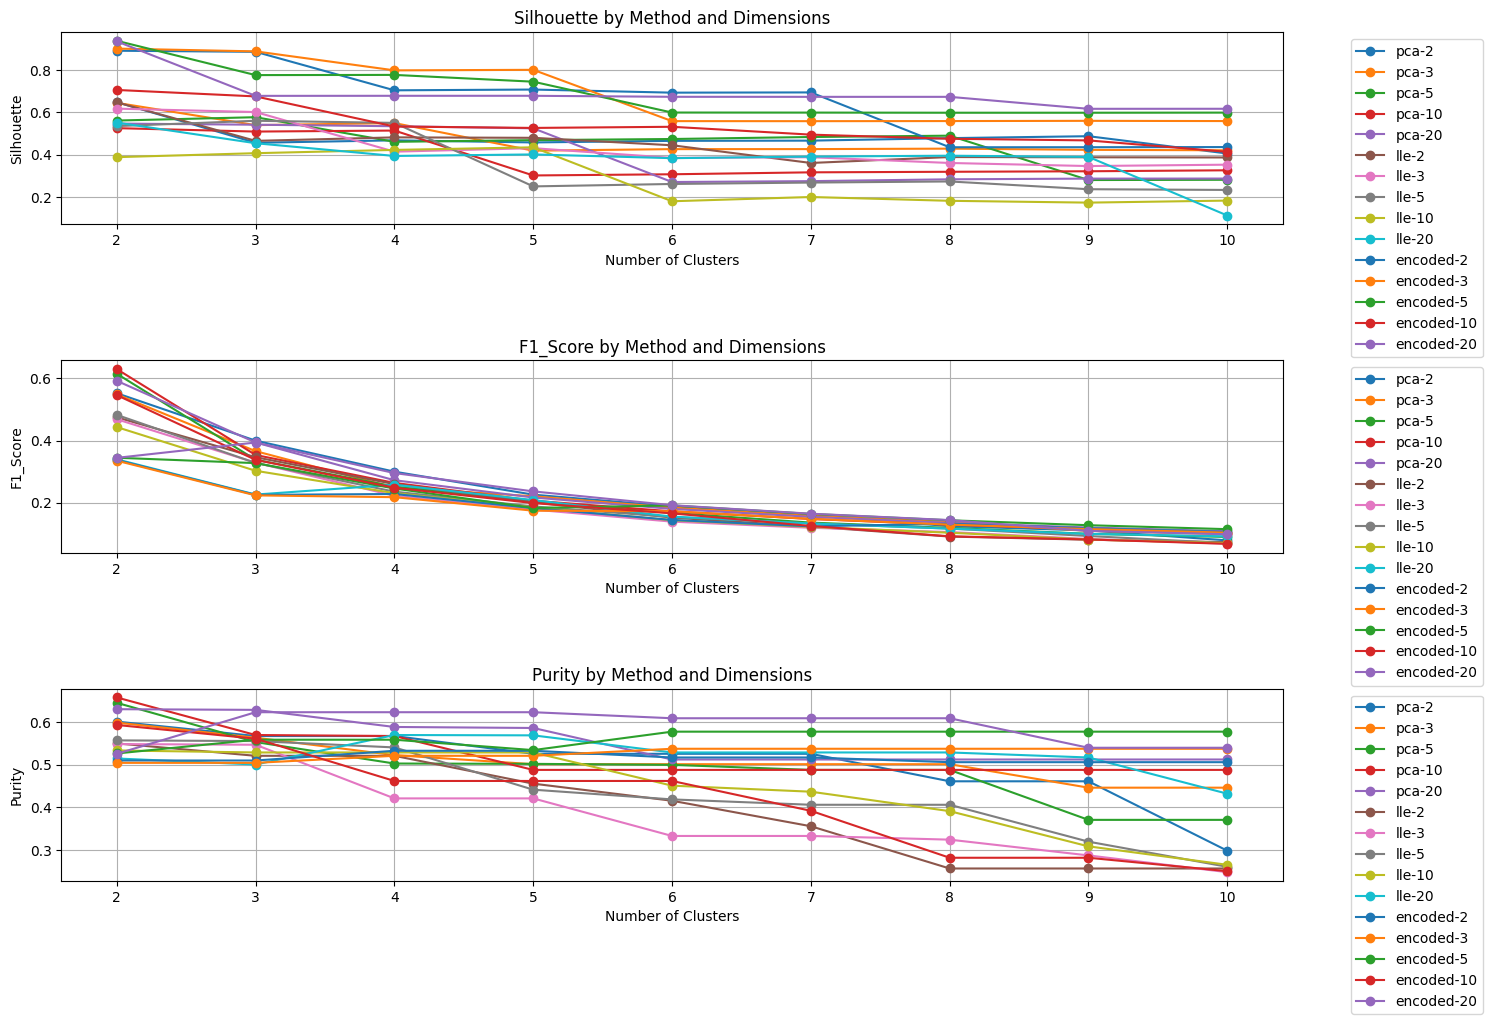

In [50]:
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import f1_score, silhouette_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



# Define parameters to test
methods = ['pca', 'lle', 'encoded']
dimensions = [2, 3, 5, 10, 20]
n_clusters_range = range(2, 11)

# Initialize a dataframe to store results
results = []

# Load true labels once
try:
    y_true = np.load('/content/drive/MyDrive/ml2025/y_val.npy')
    print(f"Loaded validation labels. Shape: {y_true.shape}")
except FileNotFoundError:
    print("Warning: y_val.npy not found. Make sure to provide the correct path.")
    # Placeholder for missing y_true
    y_true = None

# Main evaluation loop
for method in methods:
    for M in dimensions:
        try:
            # Load data based on dimensionality reduction method
            X_val = np.load(f'/content/drive/MyDrive/ml2025/X_val_{method}{M}.npy')
            print(f"\nEvaluating {method.upper()} with M={M}, data shape: {X_val.shape}")

            for n_clusters in tqdm(n_clusters_range, desc=f"{method}-{M}"):
                try:
                    # Apply Agglomerative Clustering with default ward linkage
                    clustering = AgglomerativeClustering(n_clusters=n_clusters)
                    y_pred = clustering.fit_predict(X_val)

                    # Calculate silhouette score
                    silhouette = silhouette_score(X_val, y_pred)

                    # Only calculate these metrics if we have true labels
                    if y_true is not None:
                        # Align predicted labels
                        y_pred_aligned = best_map(y_true, y_pred)

                        # Calculate F1 score with aligned labels
                        f1 = f1_score(y_true, y_pred_aligned, average='macro')

                        # Calculate purity score
                        purity = purity_score(y_true, y_pred)
                    else:
                        f1, purity = 0, 0

                    # Display results
                    # print(f"Method={method}, M={M}, Clusters={n_clusters}")
                    # print(f"  F1 Score: {f1:.4f}")
                    # print(f"  Purity Score: {purity:.4f}")
                    # print(f"  Silhouette Score: {silhouette:.4f}")

                    # Store results in list
                    results.append({
                        'Method': method,
                        'Dimensions': M,
                        'Clusters': n_clusters,
                        'F1_Score': f1,
                        'Purity': purity,
                        'Silhouette': silhouette
                    })
                except Exception as e:
                    print(f"Error with {method}, M={M}, clusters={n_clusters}: {e}")
        except FileNotFoundError as e:
            print(f"Skipping {method} with M={M}: {e}")
        except Exception as e:
            print(f"Error processing {method} with M={M}: {e}")

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
print("\nCompleted all evaluations!")


# Visualize results
plt.figure(figsize=(15, 10))

# Plot metrics across methods and dimensions
for i, metric in enumerate(['Silhouette', 'F1_Score', 'Purity']):
    plt.subplot(3, 1, i+1)
    for method in methods:
        method_data = results_df[results_df['Method'] == method]
        if not method_data.empty:
            for dim in dimensions:
                dim_data = method_data[method_data['Dimensions'] == dim]
                if not dim_data.empty:
                    plt.plot(dim_data['Clusters'], dim_data[metric],
                            marker='o', label=f"{method}-{dim}")

    plt.title(f'{metric} by Method and Dimensions')
    plt.xlabel('Number of Clusters')
    plt.ylabel(metric)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

plt.tight_layout()


# Find best performers
print("\nTop 10 configurations by Silhouette Score:")
top_silhouette = results_df.sort_values('Silhouette', ascending=False).head(10)
print(top_silhouette[['Method', 'Dimensions', 'Clusters', 'Silhouette', 'F1_Score', 'Purity']])

print("\nTop 10 configurations by F1 Score:")
top_f1 = results_df.sort_values('F1_Score', ascending=False).head(10)
print(top_f1[['Method', 'Dimensions', 'Clusters', 'F1_Score', 'Purity', 'Silhouette']])

print("\nTop 10 configurations by Purity Score:")
top_purity = results_df.sort_values('Purity', ascending=False).head(10)
print(top_purity[['Method', 'Dimensions', 'Clusters', 'Purity', 'F1_Score', 'Silhouette']])